In [1]:
from tqdm.notebook import tqdm
import sqlite3
from ratings_helpers import generate_parameters, get_backtest_predictions, compile_predictions
import pandas as pd
import itertools
from multiprocessing import Pool, cpu_count

In [2]:
from ratings_helpers import adjust_expected_points_for_oreb_prob, get_poss_df

In [3]:
pbp_df = pd.read_csv('pbp_clean.csv')
pbp_df.head()

,id,game_id,season,date,poss_id,team_id_with_poss,period,seconds_remaining_game_clock,before_event_seconds_remaining_shot_clock,event_type,...,coordinate_y,foul_stage,garbage_time_indicator,venue_id,last_free_throw,miss_prob,free_throw_source,previous_event_type,previous_possession_end,expected_points
0,4.004968e+11,400496834,2014,2013-11-08,4.004968e+11,120.0,1,1200,35.0,Jump,...,0.0,0,0,3559.0,NaN,1.000000,NaN,NaN,Other,0.000000
1,4.004968e+11,400496834,2014,2013-11-08,4.004968e+11,120.0,1,1184,19.0,Missed Shot,...,4.0,0,0,3559.0,NaN,0.579197,NaN,Jump,Other,0.841607
2,4.004968e+11,400496834,2014,2013-11-08,4.004968e+11,41.0,1,1184,35.0,DREB,...,0.0,0,0,3559.0,NaN,1.000000,NaN,Missed Shot,DREB,0.000000
3,4.004968e+11,400496834,2014,2013-11-08,4.004968e+11,41.0,1,1169,20.0,Missed Shot,...,5.0,0,0,3559.0,NaN,0.642092,NaN,DREB,DREB,0.715816
4,4.004968e+11,400496834,2014,2013-11-08,4.004968e+11,41.0,1,1169,35.0,OREB,...,0.0,0,0,3559.0,NaN,1.000000,NaN,Missed Shot,DREB,0.000000


In [4]:
df = adjust_expected_points_for_oreb_prob(pbp_df)
df.groupby('shot_type')['expected_points'].max()

shot_type
Dunk          1.999999
Free Throw    1.312231
Layup         1.997479
Long Two      1.998840
Three         2.994552
Unknown       0.000000
Name: expected_points, dtype: float64

In [11]:
pbp_df.groupby('shot_type')['expected_points'].min()

shot_type
Dunk          0.0
Free Throw    0.0
Layup         0.0
Long Two      0.0
Three         0.0
Unknown       0.0
Name: expected_points, dtype: float64

LinAlgError: singular matrix

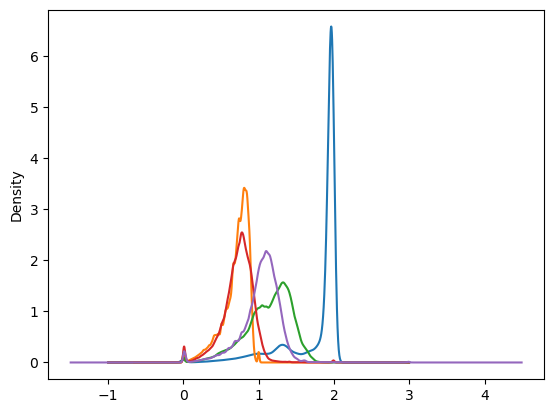

In [9]:
df.groupby('shot_type')['expected_points'].plot.kde()

In [5]:
params = generate_parameters(True)

In [6]:
poss_df = get_poss_df(df, params, season = None)
poss_df.head()

,season,game_id,date,poss_id,team_id_with_poss,previous_possession_end,possession_score_differential,final_points,garbage_time,foul_stage,seconds_elapsed,first_event,seconds_elapsed_before_first_event,opp_id,class
0,2014,400496834,2013-11-08,4.004968e+11,120.0,Other,0.0,0.757446,0,0,16.0,Long Two,16.0,41.0,long 2
1,2014,400496834,2013-11-08,4.004968e+11,41.0,DREB,0.0,1.325994,0,0,21.0,Long Two,15.0,120.0,long 2
2,2014,400496834,2013-11-08,4.004968e+11,120.0,DREB,0.0,0.410685,0,0,30.0,Long Two,30.5,41.0,long 2
3,2014,400496834,2013-11-08,4.004968e+11,41.0,DREB,0.0,0.000000,0,0,11.0,TO,11.0,120.0,to
4,2014,400496834,2013-11-08,4.004968e+11,120.0,Charge TO,0.0,0.000000,0,0,8.0,TO,8.0,41.0,to


In [ ]:
# connect to database
conn = sqlite3.connect('CBB.db')
cursor = conn.cursor()

In [ ]:
games_df = pd.read_sql('SELECT * FROM Games', conn)
pbp_df = pd.read_sql('SELECT * FROM PBP', conn)

In [ ]:
seasons = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2022]

num_iterations = 1
for n in range(num_iterations):

    # get the params we've already tried
    used_params_df = pd.read_sql('SELECT * FROM Used_Params', conn)
    used_params = used_params_df.to_dict('records')

    # generate parameters that haven't been tried before
    params = generate_parameters(True)
    while params in used_params: 
        params = generate_parameters(True)

    # add params to used params table
    params_placeholders = ', '.join('?' * len(params))
    insert_params_sql = 'INSERT INTO Used_Params VALUES ({})'.format(params_placeholders)
    cursor.execute(insert_params_sql, list(params.values()))
    conn.commit()

    p = Pool(cpu_count())

    season_inputs = list(itertools.product(seasons, [params], [games_df], [pbp_df]))

    # TODO: make sure this return statement works
    predictions = list(tqdm(p.imap(season_backtest, season_inputs), total = len(seasons)))
    p.close()
    p.join()

    predict_df = compile_predictions(predictions)

    predictions_placeholders = ', '.join('?' * len(predict_df.columns))
    insert_predictions_sql = 'INSERT INTO Predictions VALUES ({})'.format(predictions_placeholders)
    cursor.executemany(insert_predictions_sql, predict_df.to_records(index = False))

In [ ]:
conn.close()